In [ ]:
# this file contains the code necessary to automatically 
# dowload hourly weather data from the dwd-website
# based on the ID of the specific weatherstation

In [10]:
# import the necessary packages
from bs4 import BeautifulSoup
import requests
import os
import re
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
'''
function that lists all available weather stations that measure the defined weather variable

In the DWD open data archive, different temporal resolutions are available for different climate variables.
The available temporal option and the available meteorological variables can be found under the following link:

https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/
 
input: final URL that points towards the temporal resolution and the meteorological variable to investigate. 
       
output: list with all available weather stations for the specfied resolution and variable

E.g. https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/precipitation/historical/
returns a list with all available weather stations of Germany that measure houry precipitation in the past     
'''

def list_files_from_website(base_url):
    # Request the webpage content
    response = requests.get(base_url)
    
    # If the request was successful, proceed
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find all anchor tags with href attributes
        links = soup.find_all('a', href=True)
        
        # Filter out the links that likely point to files
        # (based on file extension)
        file_links = [link['href'] for link in links if '.zip' in link['href']]
        
        # Return the list of file URLs
        return file_links
    else:
        print(f"Failed to access the website. HTTP Status Code: {response.status_code}")
        return []

In [4]:
"""
Download a file based on its ID or filename from a specific base URL.

input:
base_url: string with an URL that points towards the temporal resolution and the meteorological variable to investigate. 
          choose specification from this link: 
          https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/
list_with_station_ids: list containing the strings of IDs of the weather stations
                       available weather station can be found here:
                       https://www.dwd.de/DE/fachnutzer/landwirtschaft/appl/stationskarte/_node.html 
                       or here:
                       https://www.dwd.de/DE/leistungen/klimadatendeutschland/stationsuebersicht.html                        
dest_folder: String of the folder path in which to save the downloaded data.

output:
download of the specified weather variable saved as a .zip file.
For every weather station (defined in list_with_station_ids), an individual file is saved 
"""

def download_file(base_url, list_with_station_ids, dest_folder):

    # returns a list with all available weather stations 
    # for the defined temporal resolution and meteorological variable
    files = list_files_from_website(base_url)
    
    for i in range(len(list_with_station_ids)):
        # Define your regex pattern. The naming convention of the DWD depends on the temporal resolution of the data.
        # Therefore, general patterns need to be used. 
        # The following pattern matches strings of different temporal resolution
        pattern = f"[A-Za-z]+_[A-Za-z]+_0*{list_with_station_ids[i]}_"
        
        # Construct the full URL according to the selected weather station
        file_name = [s for s in files if re.search(pattern, s)]
        file_url = os.path.join(base_url, file_name[0])

        # Make a request to download the content of the file (as a .zip)
        response = requests.get(file_url, stream=True)

        # Check if the request was successful
        if response.status_code == 200:
            # Create destination path
            dest_path = os.path.join(dest_folder, file_name[0])

            # Write the content to a file
            with open(dest_path, 'wb') as file:
                for chunk in response.iter_content(chunk_size=8192):
                    file.write(chunk)
            
            print(f"File {file_name[0]} downloaded successfully to {dest_path}")
        else:
            print(f"Failed to download the file. HTTP Status Code: {response.status_code}")

### Example: Download hourly temperature data for two different weather stations 

In [ ]:
# define base url, station ids and destination folder
base_url = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/historical/"
station_id=[1544,5158]
dest_folder = ".../weather_data/"

# execute the function to download the hourly precipitation data in the destination folder
# for every station, a .zip file with the data is saved
download_file(base_url, station_id, dest_folder)

### Example: Process the date. Here, daily temperature values are calculated from hourly values.

In [15]:
'''
load the meteorological data and reduce the file to fit the defined start and end date

input: 
path: string of the path pointing to the .csv/.txt file that contains the measurement data of meteorological variable 
date_start: integer of the starting date (format YYYYMMDDHH)
date_end: integer of the starting end (format YYYYMMDDHH)

output: 
met_var: pandas dataframe with data of the meteorological variable, but reduced to the selected date
'''

def load_csv_and_sel_date(path, date_start, date_end):

    met_var = pd.read_csv(path, sep=';')
    met_var = met_var.iloc[np.where((met_var["MESS_DATUM"]>=date_start) & (met_var["MESS_DATUM"]<=date_end))[0]]
    met_var["MESS_DATUM"] = met_var["MESS_DATUM"].astype(int)
    met_var = met_var.set_index("MESS_DATUM")
    
    return met_var

In [130]:
'''
calculates running averages of the selected meteorological variable by applying a moving average of a specified lenght
A length of 24 calculates daily values from hourly values, a length of 12 calculates yearly averages from monthly averages, etc.

input: 
path_to_weather_station: string of the path pointing to the .csv/.txt file that contains the measurement data of meteorological variable
var_name: string of the variable name of the investigated meteorological variable
start_date: integer of the starting date (format YYYYMMDDHH)
end_date: integer of the starting end (format YYYYMMDDHH)

ouput:
met_data_run_avg: np.array that contains the running average of 24 hour steps. 
'''

def daily_avgs(path_to_weather_station, var_name, length_of_run_avg, start_date, end_date):
    
    # get the csv/txt file that contains the formerly downloaded hourly values of the selected weather station
    # the historical data contains multiple years, which is why a start and end date need to be defined
    avg_id = load_csv_and_sel_date(path_to_weather_station, station_id, start_date, end_date)

    # extract values of the selected variable name and set nan values to 0
    met_data = avg_id[var_name]
    met_data[avg_id[var_name]==-999] = 0

    # calculate the running mean
    met_data_daily = met_data.rolling(length_of_run_avg).mean() 
    met_data_daily = met_data_daily.iloc[::length_of_run_avg]
    met_data_run_avg = np.convolve(met_data_daily, np.ones(7)/7, mode='valid')

    return met_data_run_avg

In [ ]:
# set start date and end date (here, it is for the year 2015), as well as the path to the weather station 
start_date = 2015010100
end_date = 2015123123
path_to_weather_station = '.../temperature.txt'

temp_2015 =  daily_avgs(path_to_weather_station,start_date, end_date)

# the same can be done for other years, too, to daily averages for multple years
# paths and dates need to be adjusted accordingly
prec_2016, temp_2016, wind_2016, humidity_2016 = daily_avgs(path_to_weather_station_2016,2016010100, 2016123123)
prec_2017, temp_2017, wind_2017, humidity_2017 = daily_avgs(path_to_weather_station_2017,2017010100, 2017123123)
prec_2018, temp_2018, wind_2018, humidity_2018 = daily_avgs(path_to_weather_station_2018,2018010100, 2018123123)
prec_2019, temp_2019, wind_2019, humidity_2019 = daily_avgs(path_to_weather_station_2019,2019010100, 2019123123)
prec_2020, temp_2020, wind_2020, humidity_2020 = daily_avgs(path_to_weather_station_2020,2020010100, 2020123123)
prec_2021, temp_2021, wind_2021, humidity_2021 = daily_avgs(path_to_weather_station_2021,2021010100, 2021123123)
prec_2022, temp_2022, wind_2022, humidity_2022 = daily_avgs(path_to_weather_station_2022,2022010100, 2022123123)

# the resulting data is used to createa a pandas dataframe for plotting
temp = pd.DataFrame({
    '2015': temp_2015[0:354],
    '2016': temp_2016[0:354],
    '2017': temp_2017[0:354],
    '2018': temp_2018[0:354],
    '2019': temp_2019[0:354],
    '2020': temp_2020[0:354],
    '2021': temp_2021[0:354],
    '2022': temp_2022[0:354],
})

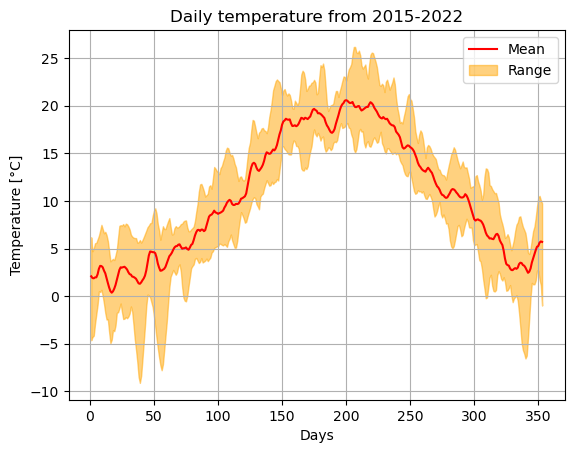

In [214]:
# the average temperature of all years is plotted for every day of the year
# the temperature range is defined by the min and max values of every day

mean_temp = np.mean(temp, axis=1)
min_temp = np.min(temp, axis=1)
max_temp = np.max(temp, axis=1)

# Plot the mean values
plt.plot(range(0,len(mean_temp)), mean_temp, color='red', label = 'Mean')
# Shade the region between mean - 1 std and mean + 1 std
plt.fill_between(range(0,len(mean_temp)), min_temp, max_temp, color='orange', alpha=0.5, label='Range')

plt.title('Daily temperature from 2015-2022')
plt.xlabel('Days')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.grid(True)
plt.show()